In [2]:
!pip install pybboxes
!pip install ultralytics

  Using cached ultralytics-8.3.176-py3-none-any.whl.metadata (37 kB)
  Using cached ultralytics_thop-2.0.15-py3-none-any.whl.metadata (14 kB)
  Using cached numpy-2.2.6-cp311-cp311-manylinux_2_17_x86_64.manylinux2014_x86_64.whl.metadata (62 kB)
  Using cached nvidia_cuda_nvrtc_cu12-12.4.127-py3-none-manylinux2014_x86_64.whl.metadata (1.5 kB)
  Using cached nvidia_cuda_runtime_cu12-12.4.127-py3-none-manylinux2014_x86_64.whl.metadata (1.5 kB)
  Using cached nvidia_cuda_cupti_cu12-12.4.127-py3-none-manylinux2014_x86_64.whl.metadata (1.6 kB)
  Using cached nvidia_cudnn_cu12-9.1.0.70-py3-none-manylinux2014_x86_64.whl.metadata (1.6 kB)
  Using cached nvidia_cublas_cu12-12.4.5.8-py3-none-manylinux2014_x86_64.whl.metadata (1.5 kB)
  Using cached nvidia_cufft_cu12-11.2.1.3-py3-none-manylinux2014_x86_64.whl.metadata (1.5 kB)
  Using cached nvidia_curand_cu12-10.3.5.147-py3-none-manylinux2014_x86_64.whl.metadata (1.5 kB)
  Using cached nvidia_cusolver_cu12-11.6.1.9-py3-none-manylinux2014_x86_64.w

In [32]:
# Imports
import os
import cv2
from google.colab import drive
from google.colab import files
from google.colab.patches import cv2_imshow
from ultralytics import YOLO

File Upload Part

In [36]:
#Folder paths
upload_folder = 'uploaded_images'
anonymized_folder = '/content/gdrive/MyDrive/anonymized_images'

# Check the folders
os.makedirs(upload_folder, exist_ok=True)
os.makedirs(anonymized_folder, exist_ok=True)

print("Please upload the image")
uploaded = files.upload()

if not uploaded:
    print("No file!!!")
else:
    # Get the filename and define its path
    filename = list(uploaded.keys())[0]
    uploaded_image_path = os.path.join(upload_folder, filename)

    # Write the file to the upload folder
    with open(uploaded_image_path, 'wb') as f:
        f.write(uploaded[filename])
    print(f'Image "{filename}" uploaded successfully and saved to: {uploaded_image_path}')

Please upload the image


Saving -2024-09-28-220720_png.rf.b7fdc328087c67acd13015266a61b190.jpg to -2024-09-28-220720_png.rf.b7fdc328087c67acd13015266a61b190.jpg
Image "-2024-09-28-220720_png.rf.b7fdc328087c67acd13015266a61b190.jpg" uploaded successfully and saved to: uploaded_images/-2024-09-28-220720_png.rf.b7fdc328087c67acd13015266a61b190.jpg


Anonymize

https://github.com/rakiiibul/LF_Anonymization.git  This repo was used for below anonymos code

Image loaded. Running object detection...

0: 640x640 4 cars, 1 bus, 4 traffic lights, 387.6ms
Speed: 4.0ms preprocess, 387.6ms inference, 2.4ms postprocess per image at shape (1, 3, 640, 640)
🔎 Found 9 objects to anonymize.
Anonymization complete! Anonymized image saved to: /content/gdrive/MyDrive/anonymized_images/-2024-09-28-220720_png.rf.b7fdc328087c67acd13015266a61b190.jpg

Anonymized Image:


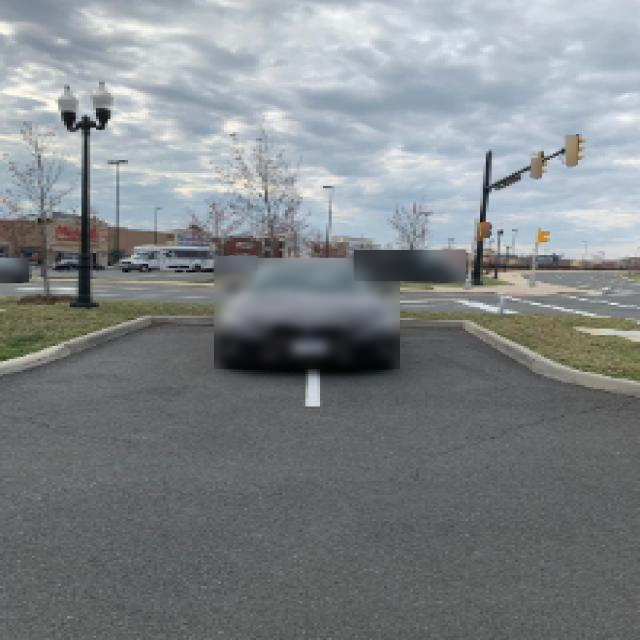

In [37]:
# Load anonymous model
det_model_path = '/content/gdrive/MyDrive/yolov8n.pt'

# Helper function to blur regions
def anonymize(image, regions):
    for region in regions:
        x1, y1, x2, y2 = region
        # Ensure coordinates are within image boundaries
        x1, y1, x2, y2 = max(0, x1), max(0, y1), min(image.shape[1], x2), min(image.shape[0], y2)
        roi = image[y1:y2, x1:x2]
        if roi.size > 0:
            blurred_roi = cv2.GaussianBlur(roi, (31, 31), 0)
            image[y1:y2, x1:x2] = blurred_roi
    return image

# --- Anonymization Logic ---
try:
    det_model = YOLO(det_model_path)
    # Read the original image that was uploaded in the previous cell
    original_image = cv2.imread(uploaded_image_path)

    if original_image is None:
        print(f"Error: Could not read the image from '{uploaded_image_path}'. Please re-run the upload cell.")
    else:
        print("Image loaded. Running object detection...")
        results = det_model(source=original_image, save=False, conf=0.2, device='cpu')

        bboxes = [box.xyxy[0].cpu().numpy().astype(int) for box in results[0].boxes]
        print(f"🔎 Found {len(bboxes)} objects to anonymize.")

        # Apply the blurring
        anonymized_image = anonymize(original_image.copy(), bboxes)

        # Define the full path for the output file in Google Drive
        anonymized_image_path = os.path.join(anonymized_folder, filename)
        cv2.imwrite(anonymized_image_path, anonymized_image)

        print(f"Anonymization complete! Anonymized image saved to: {anonymized_image_path}")
        # Display the anonymized image
        print("\nAnonymized Image:")
        cv2_imshow(anonymized_image)

except Exception as e:
    print(f"An error occurred during anonymization: {e}")

Prediction

Loading anonymized image from /content/gdrive/MyDrive/anonymized_images/-2024-09-28-220720_png.rf.b7fdc328087c67acd13015266a61b190.jpg and analyzing...

image 1/1 /content/gdrive/MyDrive/anonymized_images/-2024-09-28-220720_png.rf.b7fdc328087c67acd13015266a61b190.jpg: 640x640 1 parking_issues, 677.5ms
Speed: 3.0ms preprocess, 677.5ms inference, 2.0ms postprocess per image at shape (1, 3, 640, 640)
Detected Object:  parking_issues
 -> Main Category: Road Issues
 -> Confidence:    0.51


Displaying processed image:


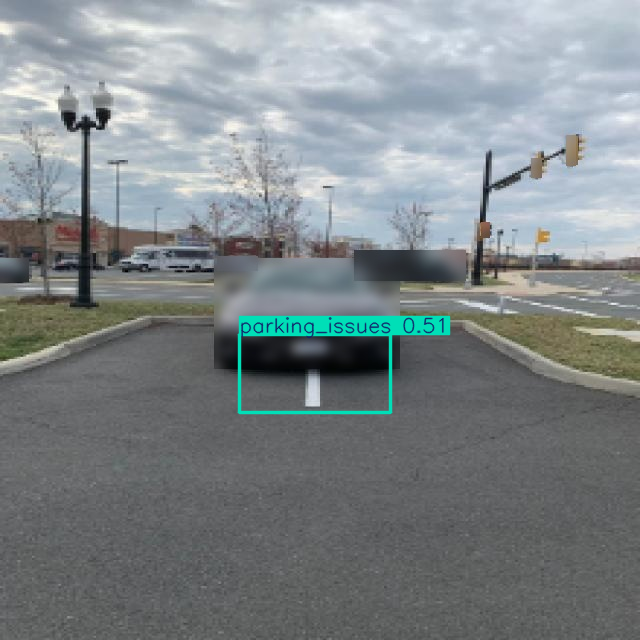

In [38]:
# Load the best.pt detection model
detection_model_path = '/content/gdrive/MyDrive/best.pt'

try:
    model = YOLO(detection_model_path)

    # Perform detection on the ANONYMIZED image
    print(f"Loading anonymized image from {anonymized_image_path} and analyzing...")
    results = model.predict(source=anonymized_image_path)

    if len(results[0].boxes) > 0:

        # issues
        road_issue_classes = ["broken_road_signs", "damaged_buildings", "parking_issues", "potholes"]
        environmental_issue_classes = ["littering", "vandalism"]

        for box in results[0].boxes:
            class_id = int(box.cls[0])
            predicted_class = model.names[class_id]
            confidence = box.conf[0].item()

            # Check the Main Category
            if predicted_class in road_issue_classes:
                main_category = "Road Issues"
            elif predicted_class in environmental_issue_classes:
                main_category = "Environmental Issues"
            else:
                main_category = "Other Issues"

            # results printing
            print(f"Detected Object:  {predicted_class}")
            print(f" -> Main Category: {main_category}")
            print(f" -> Confidence:    {confidence:.2f}")

    else:
        print("Final Result:")
        print("No specific issues detected.")

    # Display the final processed image
    print("\n\nDisplaying processed image:")

    # showing detections below
    final_img_with_boxes = results[0].plot()
    cv2_imshow(final_img_with_boxes)

except Exception as e:
    print(f"It didn't work: {e}")